In [1]:
import mne
# Importing numpy 
import numpy as np
# Importing Scipy 
import scipy as sp
# Importing Pandas Library 
import pandas as pd
# import glob function to scrap files path
from glob import glob
# import display() for better visualitions of DataFrames and arrays
from IPython.display import display
# import pyplot for plotting
import matplotlib.pyplot as plt
import math
from skimage.restoration import denoise_wavelet
from scipy.signal import savgol_filter
from scipy.signal import medfilt
import seaborn as sns
import pywt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

from models.EEGNet import *

In [3]:
#band pass filter between 0.5 and 40 hz
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
from scipy.signal import medfilt # import the median filter function
def median(signal, kernel_size=3):# input: numpy array 1D (one column)
    array=np.array(signal)   
    #applying the median filter
    med_filtered=sp.signal.medfilt(array, kernel_size=kernel_size) # applying the median filter order3(kernel_size=3)
    return  med_filtered # return the med-filtered signal: numpy array 1D
#notch filter apllied at 50hz
def Implement_Notch_Filter(time, band, freq, ripple, order, filter_type, data):
    from scipy.signal import iirfilter
    fs   = 256#1/time
    nyq  = fs/2.0
    low  = freq - band/2.0
    high = freq + band/2.0
    low  = low/nyq
    high = high/nyq
    b, a = iirfilter(order, [low, high], rp=ripple, btype='bandstop',
                     analog=False, ftype=filter_type)
    filtered_data = lfilter(b, a, data)
    return filtered_data

In [4]:
# base_model = EEGNet(
#     nb_classes=1, Chans = 4, Samples = 128, 
#     dropoutRate = 0.5, kernLength = 34, F1 = 8, 
#     D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'
# )
base_model = EEGNet_SSVEP(
    nb_classes = 1, Chans = 4, Samples = 128, 
    dropoutRate = 0.5, kernLength = 50, F1 = 96, 
    D = 1, F2 = 96, dropoutType = 'Dropout'
)
x = base_model.layers[-3].output
x = Dense(128*2, activation='relu')(x)
x = Reshape((128, 2))(x)
x = Activation('softmax', name = 'softmax')(x)
model = Model(inputs=base_model.input, outputs=x)
model.summary()

model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam',
    metrics=['accuracy']
)

model.load_weights(r'.\checkpoints\eyebrows\eegnet_ssvep_v1.weights.h5')
# model.load_weights(r'.\checkpoints\eyebrows\eegnet_v2.weights.h5')

d:\FPTU\THESIS\thesis\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4, 128, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 4, 128, 96)     │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 128, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 1, 128, 96)     │           384 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 128, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1, 128, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 32, 96)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 32, 96)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 1, 32, 96)      │        10,752 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 32, 96)      │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1, 32, 96)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 1, 4, 96)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 128, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 128, 2)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,648 (451.75 KB)

 Trainable params: 115,072 (449.50 KB)

 Non-trainable params: 576 (2.25 KB)

d:\FPTU\THESIS\thesis\lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [5]:
label_name = 'eyebrows'
trial = 3
# df = pd.read_csv(r'.\inference_data\eyebrows.csv').drop(columns=['timestamps', 'Right AUX'])
df = pd.read_csv(fr'.\raw_data\{label_name}\{label_name}_{trial}.csv').drop(columns=['timestamps', 'Right AUX'])
df.head()

,TP9,AF7,AF8,TP10
0,-35.645,-56.152,-42.969,-26.367
1,-58.105,-65.918,-42.969,-29.297
2,-27.344,-59.570,-49.805,-24.414
3,13.184,-41.016,-48.828,-15.625
4,-4.883,-33.691,-44.922,-15.625


In [6]:
import joblib
scaler = joblib.load('checkpoints/eyebrows/scaler.save') 

In [7]:
# Split then filtered
n_timesteps = 128
data = df.to_numpy()
input_data = []
for i in range(0, data.shape[0] // n_timesteps * n_timesteps, n_timesteps):
    input = data[i:i+n_timesteps].copy()
    for column in range(input.shape[1]):
        x=np.array(input[:, column]) # copie the signal values in 1D numpy array
        fs = 256
        lowcut = 20
        highcut = 49
        x=butter_bandpass_filter(x, lowcut, highcut, fs, order=3)
        x=median(x, 5)
        x=savgol_filter(x, 10, polyorder=5 ,mode='nearest')
        input[:, column] = x
    input = scaler.transform(input)
    input_data.append(input) 
input_data = np.array(input_data)
input_data = input_data.transpose(0, 2, 1)
input_data = input_data[:, :, :, np.newaxis]
input_data.shape

d:\FPTU\THESIS\thesis\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\FPTU\THESIS\thesis\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\FPTU\THESIS\thesis\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\FPTU\THESIS\thesis\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\FPTU\THESIS\thesis\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\FPTU\THESIS\thesis\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

(110, 4, 128, 1)

In [8]:
y_pred = model.predict(input_data)
y_pred.shape

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step


(110, 128, 2)

In [9]:
y_pred = np.argmax(y_pred, axis=2)
y_pred = np.concatenate(y_pred)
y_pred.shape, np.unique(y_pred, return_counts=True)

((14080,), (array([0, 1], dtype=int64), array([13250,   830], dtype=int64)))

In [10]:
plot_data = np.squeeze(input_data).transpose(0, 2, 1)
plot_data = np.concatenate(plot_data)
plot_data.shape

(14080, 4)

In [11]:
y_true = np.zeros(y_pred.shape)
# roi = pd.read_csv(r'.\inference_data\eyebrows_roi.csv').to_numpy()
roi = pd.read_csv(rf'.\roi_v2\{label_name}\{label_name}_{trial}.csv').to_numpy()
for row in roi:
    y_true[row[0]:row[1]] = row[2]
y_true

array([0., 0., 0., ..., 0., 0., 0.])

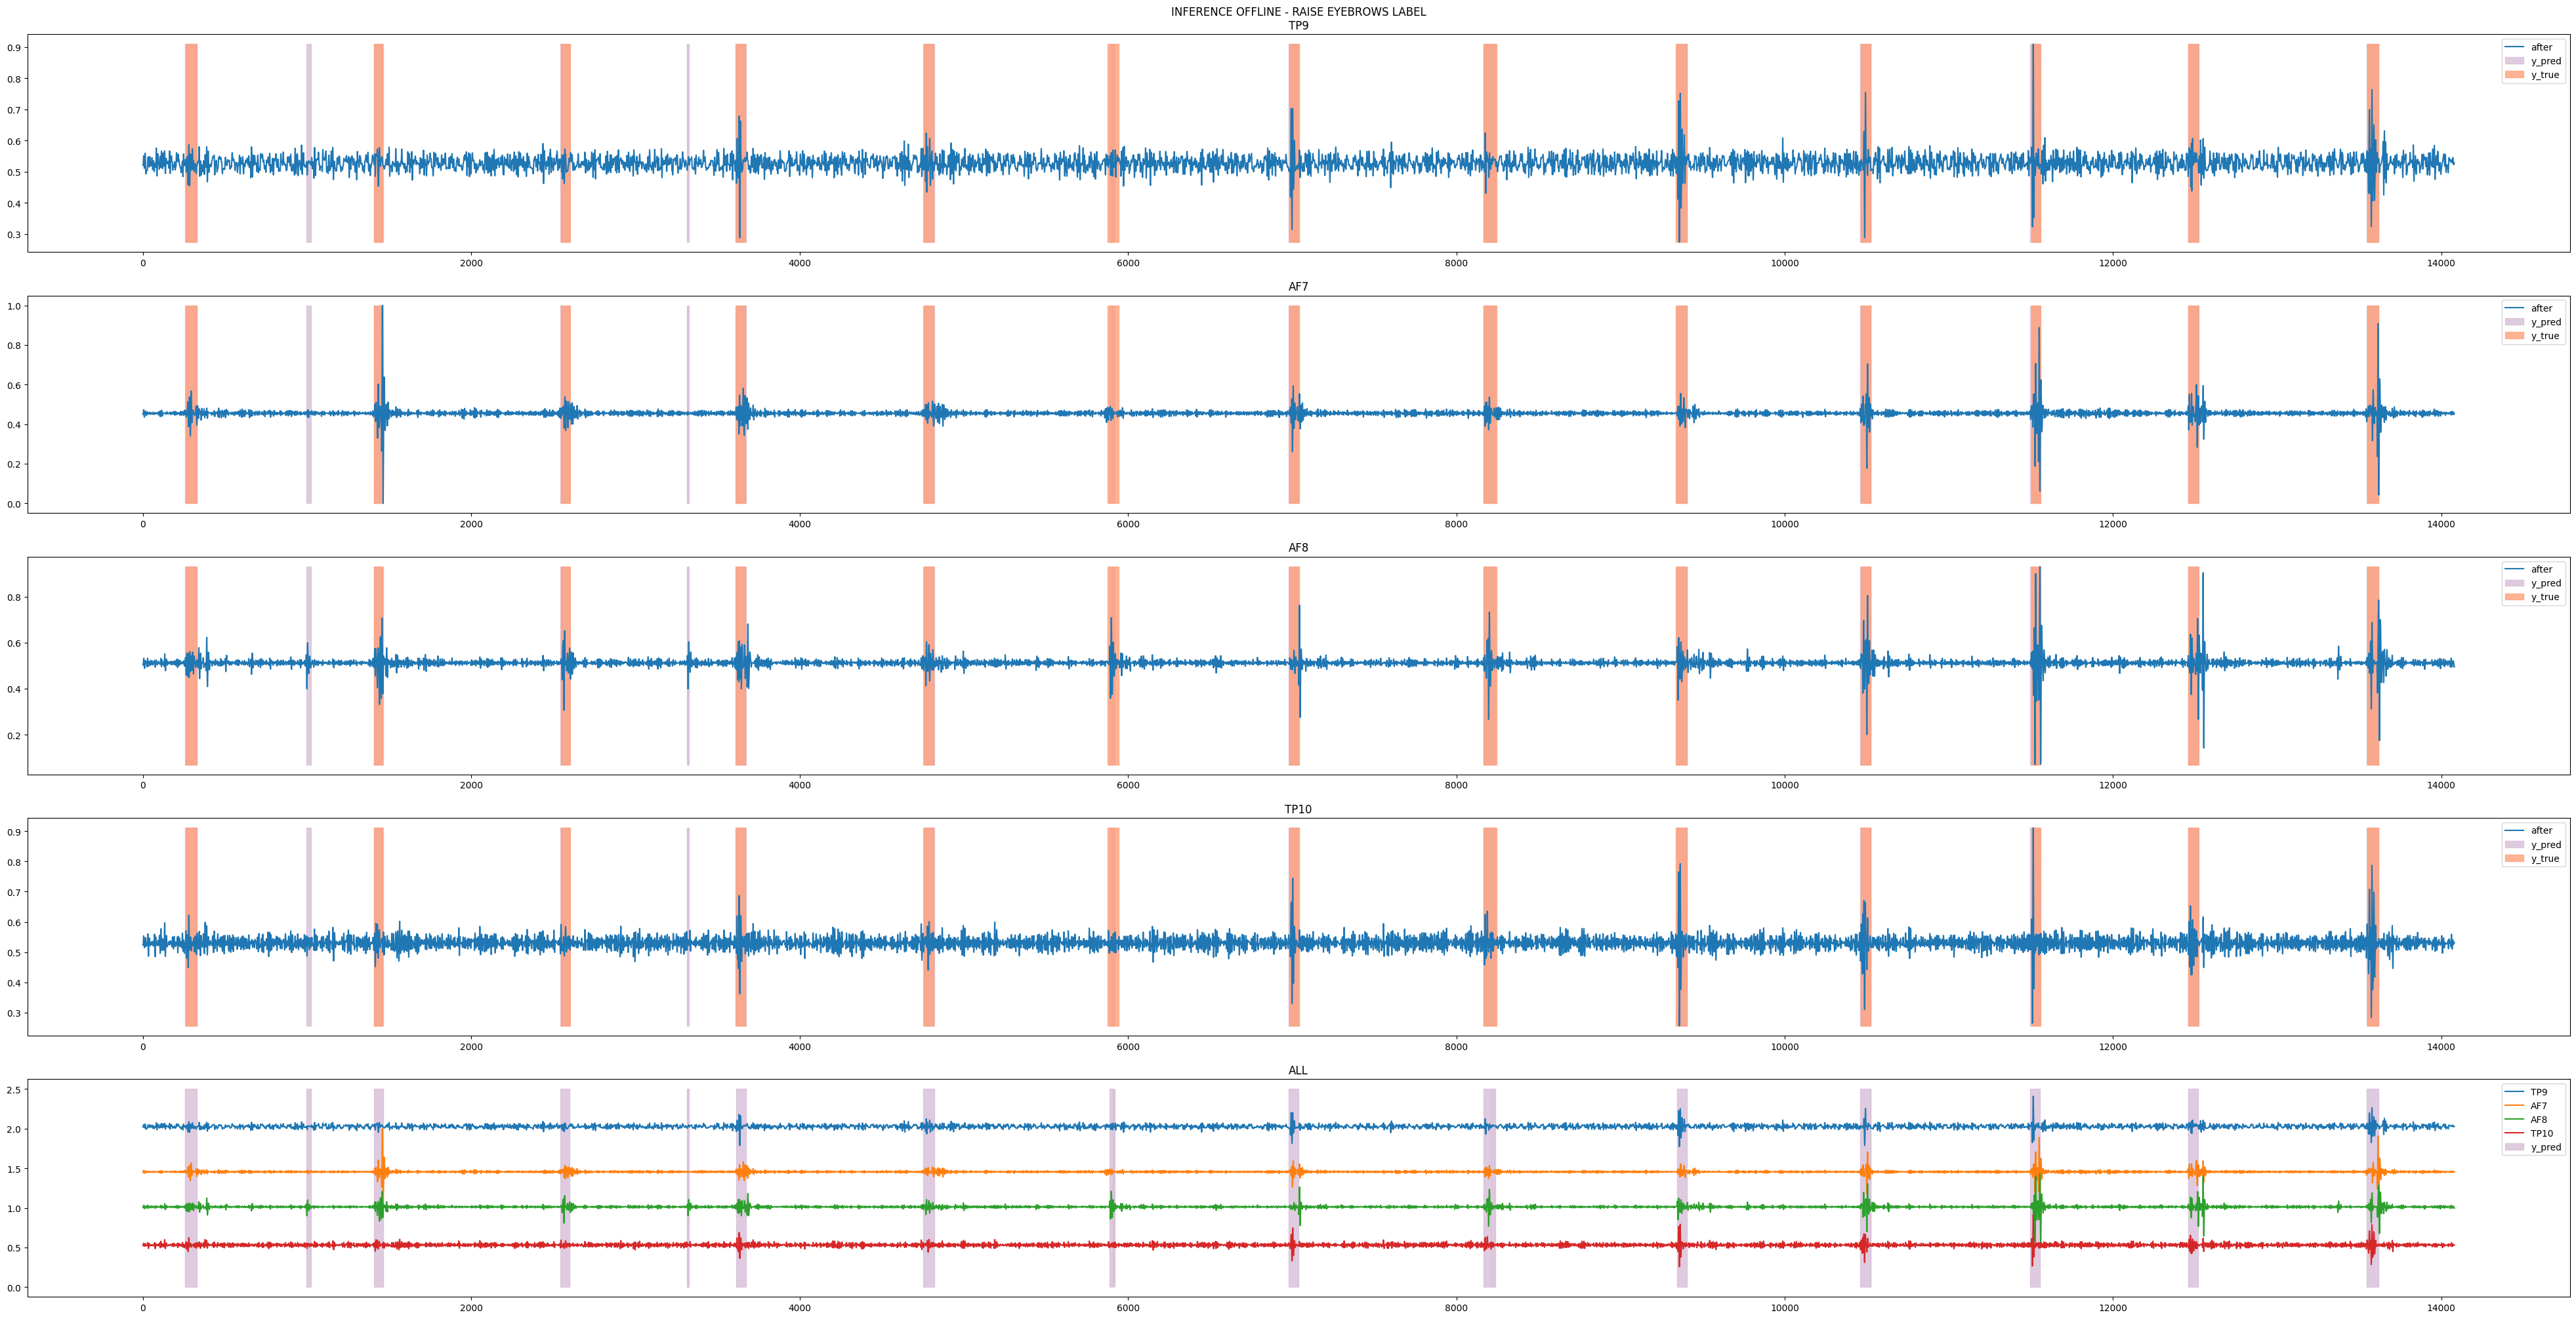

In [12]:
plt.figure(figsize=(50,25), dpi=None)
plt.subplot(5, 1, 1)
plt.title('INFERENCE OFFLINE - RAISE EYEBROWS LABEL\nTP9')
# plt.plot(data[:, 0], label='before')
plt.plot(plot_data[:, 0], label='after')
plt.fill_between(
    list(range(plot_data.shape[0])), 
    plot_data[:, 0].min(), 
    plot_data[:, 0].max(),
    where=y_pred, alpha=0.8, color='thistle', label='y_pred'
)
plt.fill_between(
    list(range(plot_data.shape[0])), 
    plot_data[:, 0].min(), 
    plot_data[:, 0].max(),
    where=y_true, alpha=0.8, color='lightsalmon', label='y_true'
)
plt.legend()

plt.subplot(5, 1, 2)
plt.title('AF7')
# plt.plot(data[:, 1], label='before')
plt.plot(plot_data[:, 1], label='after')
plt.fill_between(
    list(range(plot_data.shape[0])), 
    plot_data[:, 1].min(), 
    plot_data[:, 1].max(),
    where=y_pred, alpha=0.8, color='thistle', label='y_pred'
)
plt.fill_between(
    list(range(plot_data.shape[0])), 
    plot_data[:, 1].min(), 
    plot_data[:, 1].max(),
    where=y_true, alpha=0.8, color='lightsalmon', label='y_true'
)
plt.legend()

plt.subplot(5, 1, 3)
plt.title('AF8')
# plt.plot(data[:, 2], label='before')
plt.plot(plot_data[:, 2], label='after')
plt.fill_between(
    list(range(plot_data.shape[0])), 
    plot_data[:, 2].min(), 
    plot_data[:, 2].max(),
    where=y_pred, alpha=0.8, color='thistle', label='y_pred'
)
plt.fill_between(
    list(range(plot_data.shape[0])), 
    plot_data[:, 2].min(), 
    plot_data[:, 2].max(),
    where=y_true, alpha=0.8, color='lightsalmon', label='y_true'
)
plt.legend()

plt.subplot(5, 1, 4)
plt.title('TP10')
# plt.plot(data[:, 3], label='before')
plt.plot(plot_data[:, 3], label='after')
plt.fill_between(
    list(range(plot_data.shape[0])), 
    plot_data[:, 3].min(), 
    plot_data[:, 3].max(),
    where=y_pred, alpha=0.8, color='thistle', label='y_pred'
)
plt.fill_between(
    list(range(plot_data.shape[0])), 
    plot_data[:, 3].min(), 
    plot_data[:, 3].max(),
    where=y_true, alpha=0.8, color='lightsalmon', label='y_true'
)
plt.legend()

plt.subplot(5, 1, 5)
plt.title('ALL')
plt.plot(plot_data + [1.5, 1, 0.5, 0], label=['TP9', 'AF7', 'AF8', 'TP10'])
# plt.plot(plot_data + [100, 0], label=['TP9', 'TP10'])
plt.fill_between(
    list(range(plot_data.shape[0])), 
    plot_data.min(), 
    2.5, #plot_data.max(),
    where=y_pred, alpha=0.8, color='thistle', label='y_pred'
)
# plt.fill_between(
#     list(range(plot_data.shape[0])), 
#     plot_data.min(), 
#     2.5, #plot_data.max(),
#     where=y_true, alpha=0.8, color='lightsalmon', label='y_true'
# )
plt.legend()